In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.size'] = 15

# Prepare routines

- tridiagonal matrix multiplication

In [2]:
from tdse.matrix_py import mat_vec_mul_tridiag, gaussian_elimination_tridiagonal

def tridiag_forward(tridiag, v, b):
    b[:] = mat_vec_mul_tridiag(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], v)

def tridiag_backward(tridiag, v, b):
    v[:] = gaussian_elimination_tridiagonal(tridiag[1,:], tridiag[0,1:], tridiag[2,:-1], b)

# Parameter

- may be replaced by input file read

In [3]:
R_in = 200.03
delta_x = 0.2
imag_pot_width = 30.0
delta_t_real = 0.05
t0 = 0.0
# imag_prop = False

# V_x_func = lambda x: np.zeros_like(x)
V_x_func = lambda x: - np.exp(-0.01*x*x) * 0.5

# omega_pot = np.sqrt(0.002)
# V_x_func = lambda x: 0.5 * omega_pot*omega_pot * x*x

omega = 0.5
num_cycle = 2
A0 = 2.0
def A_t_func_single(t):
    global omega, num_cycle
    _duration = num_cycle * 2.0 * np.pi / omega
    if t > _duration: return 0.0
    return A0 * np.square(np.sin(omega / (2*num_cycle) * t)) * np.sin(omega*t + np.pi/2.0)
A_t_func = np.vectorize(A_t_func_single)

pulse_duration = num_cycle * 2.0 * np.pi / omega
t_max_in = 2.5 * pulse_duration

### Derived variables

### Check parameters

In [4]:
assert R_in > 0 and delta_x > 0 and imag_pot_width > 0 and delta_t_real > 0

# Develop Object : `system` etc.

In [5]:
from tdse.integral import normalize_trapezoid
from numbers import Integral

from tdse.evol import get_M2_tridiag, get_D2_tridiag, mul_tridiag_and_diag, get_M1_tridiag, get_D1_tridiag



class System(object): pass

class LinearPolariVelocityGaugeSystem(System):
    def __init__(self, 
                 R_in, delta_x, delta_t_real, 
                 t0, imag_pot_width, V_x_func, 
                 omega, num_cycle, A0, A_t_func, t_max_in,
                sf_arr):
        
        ## Check input arguments
        
        ## Construct spatial array
#         self.delta_x= delta_x
#         self.N_x = 2 * int(R_in // self.delta_x) + 1
#         N_x_width = self.N_x // 2
#         self.R = self.delta_x * N_x_width
#         assert self.R == (R_in - (R_in % self.delta_x))  # check consistency
#         self.x_arr = np.linspace(-self.R, self.R, self.N_x)
#         assert np.isclose(self.x_arr[1] - self.x_arr[0],self.delta_x, atol=1e-13, rtol=0)  # check consistency
        
        self.delta_x = delta_x
        self.x_arr = self.construct_spatial_array(self.delta_x, R_in)
        self.N_x = self.x_arr.size
        self.R = self.x_arr[-1]
        
        ## Construct temporal array
        self.delta_t_real = delta_t_real
        self.t0 = t0
        self.N_timestep = int( (t_max_in - self.t0 + self.delta_t_real) // self.delta_t_real )
        self.t_max = self.t0 + self.delta_t_real * self.N_timestep
        self.N_timepoint = self.N_timestep + 1
        self.t_arr = np.linspace(self.t0, self.t_max, self.N_timepoint)
        assert np.isclose(self.t_arr[1] - self.t_arr[0], self.delta_t_real, atol=1e-14, rtol=0)  # check consistency
        
        ## Assign to members
        self.A_t_func = A_t_func
        self.V_x_func = V_x_func
        
        ## SEt the initial state function array
        self.sf_arr = np.empty_like(self.x_arr, dtype=complex)
        if sf_arr is None: self.sf_arr[:] = np.random.rand(self.N_x) - 0.5
        else: self.sf_arr[:] = sf_arr
        assert self.sf_arr is not None
        
        ##
        self.V_x_arr = self.V_x_func(self.x_arr)
        
        
        ## Evaluate static parts of matrices
        N_x = self.N_x
        delta_x = self.delta_x
        V_x_arr = self.V_x_arr
        
        self._M2 = get_M2_tridiag(N_x)
        self._D2 = get_D2_tridiag(N_x, delta_x)
        self._M1 = get_M1_tridiag(N_x)
        self._D1 = get_D1_tridiag(N_x, delta_x)
        self._M2V = mul_tridiag_and_diag(self._M2, V_x_arr)
        
        ## Allocate memory 
        # for time-evolution operator
        _tridiag_shape = (3,N_x)
        self._UA = np.empty(_tridiag_shape, dtype=complex)
        self._UA_conj = np.empty(_tridiag_shape, dtype=complex)
        self._U0_half = np.empty(_tridiag_shape, dtype=complex)
        self._U0_conj_half = np.empty(_tridiag_shape, dtype=complex)
        self._U0 = np.empty(_tridiag_shape, dtype=complex)
        self._U0_conj = np.empty(_tridiag_shape, dtype=complex)

        ## Construct unitary time evolution operators
#         self._U0_half[:] = self._M2 - 1.0j * _delta_t * 0.25 * (-0.5 * self._D2 + self._M2V)
#         self._U0_conj_half[:] = self._M2 + 1.0j * _delta_t * 0.25 * (-0.5 * self._D2 + self._M2V)
#         self._U0[:] = self._M2 - 1.0j * _delta_t * 0.5 * (-0.5 * self._D2 + self._M2V)
#         self._U0_conj[:] = self._M2 + 1.0j * _delta_t * 0.5 * (-0.5 * self._D2 + self._M2V)
        
        
        
    @staticmethod
    def construct_spatial_array(delta_x, R_in):
        """Construct spatial array"""
        N_x = 2 * int(R_in // delta_x) + 1
        N_x_width = N_x // 2
        R = delta_x * N_x_width
        assert R == (R_in - (R_in % delta_x))  # check consistency
        x_arr = np.linspace(-R, R, N_x)
        assert np.isclose(x_arr[1] - x_arr[0], delta_x, atol=1e-13, rtol=0)  # check consistency
        return x_arr

    def propagate(self, start_t_idx, num_timestep, imag_prop=False):
#                   self.t_arr, self.delta_t_real, self.A_t_func, 
#                            self.V_x_arr, self.sf_arr, self.x_arr):

        ## Check input arguments
        assert isinstance(num_timestep, Integral) and num_timestep > 0

        ## Configure time propagation
        _delta_t = self.delta_t_real
        _A_t_func = self.A_t_func
        if imag_prop:
            _delta_t *= (-1.0j)
            _A_t_func = lambda t: np.zeros_like(t)

#         N_x = x_arr.size
        N_x = self.N_x
#         self.delta_x = self.x_arr[1] - self.x_arr[0]
        M2 = get_M2_tridiag(N_x)
        D2 = get_D2_tridiag(N_x, self.delta_x)
        M2V = mul_tridiag_and_diag(M2, self.V_x_arr)
        M1 = get_M1_tridiag(N_x)
        D1 = get_D1_tridiag(N_x, self.delta_x)


        ## Allocate memory 
        # for intermediate result
        _sf_arr_mid = np.empty_like(self.x_arr, dtype=complex)
        #
        # for time-evolution operator
        _tridiag_shape = (3,N_x)
        _UA = np.empty(_tridiag_shape, dtype=complex)
        _UA_conj = np.empty(_tridiag_shape, dtype=complex)
        _U0_half = np.empty(_tridiag_shape, dtype=complex)
        _U0_conj_half = np.empty(_tridiag_shape, dtype=complex)
        _U0 = np.empty(_tridiag_shape, dtype=complex)
        _U0_conj = np.empty(_tridiag_shape, dtype=complex)

        ## Construct unitary time evolution operators
        _U0_half[:] = M2 - 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
        _U0_conj_half[:] = M2 + 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
        _U0[:] = M2 - 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)
        _U0_conj[:] = M2 + 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)


        _t_idx = start_t_idx
        _t = 0.5 * (self.t_arr[_t_idx] + self.t_arr[_t_idx+1])  # use the middle time point for each timestep
        _A_t = _A_t_func(_t)

        _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
        _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

        tridiag_forward(_U0_half, self.sf_arr, _sf_arr_mid)
        tridiag_backward(_U0_conj_half, self.sf_arr, _sf_arr_mid)
        tridiag_forward(_UA, self.sf_arr, _sf_arr_mid)
        tridiag_backward(_UA_conj, self.sf_arr, _sf_arr_mid)

        for _t_idx in range(start_t_idx+1, start_t_idx+num_timestep):

            if imag_prop: normalize_trapezoid(self.x_arr, self.sf_arr)

            _t = 0.5 * (self.t_arr[_t_idx] + self.t_arr[_t_idx+1])
            _A_t = _A_t_func(_t)

            _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
            _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

            tridiag_forward(_U0, self.sf_arr, _sf_arr_mid)
            tridiag_backward(_U0_conj, self.sf_arr, _sf_arr_mid)
            tridiag_forward(_UA, self.sf_arr, _sf_arr_mid)
            tridiag_backward(_UA_conj, self.sf_arr, _sf_arr_mid)

        tridiag_forward(_U0_half, self.sf_arr, _sf_arr_mid)
        tridiag_backward(_U0_conj_half, self.sf_arr, _sf_arr_mid)

        if imag_prop: normalize_trapezoid(self.x_arr, self.sf_arr)

# Construct coordinates arrays

## spatial array

In [6]:
# N_x = 2 * int(R_in // delta_x) + 1
# N_x_width = N_x // 2
# R = delta_x * N_x_width
# assert R == (R_in - (R_in % delta_x))  # check consistency
# x_arr = np.linspace(-R,R,N_x)
# assert np.isclose(x_arr[1] - x_arr[0],delta_x, atol=1e-13, rtol=0)  # check consistency

## temporal array

In [7]:
# N_timestep = int( (t_max_in - t0 + delta_t_real) // delta_t_real )
# t_max = t0 + delta_t_real * N_timestep
# N_timepoint = N_timestep + 1
# t_arr = np.linspace(t0, t_max, N_timepoint)
# assert np.isclose(t_arr[1] - t_arr[0], delta_t_real, atol=1e-14, rtol=0)  # check consistency

# SYS

In [8]:
x_arr = LinearPolariVelocityGaugeSystem.construct_spatial_array(delta_x, R_in)

from tdse.analytic import Gaussian1D
sf_arr_0 = Gaussian1D(x_arr, t0, k_x=0.0)
# sf_arr_0 = np.empty(sf_shape, dtype=complex)



# sf_shape = (sys.N_x,)

# sf_arr_0 = np.empty(sf_shape, dtype=complex)
# sf_arr = np.empty(sf_shape, dtype=complex)

# # sf_arr_0[:] = np.random.rand(*sf_shape) - 0.5
# from tdse.analytic import Gaussian1D
# sf_arr_0[:] = Gaussian1D(sys.x_arr, t0, k_x=0.0)

# sf_arr[:] = sf_arr_0.copy()

In [9]:
sys = LinearPolariVelocityGaugeSystem(
    R_in, delta_x, delta_t_real, 
    t0, imag_pot_width, V_x_func, 
    omega, num_cycle, A0, A_t_func, t_max_in, sf_arr=sf_arr_0)

# Set initial state function

## Plot

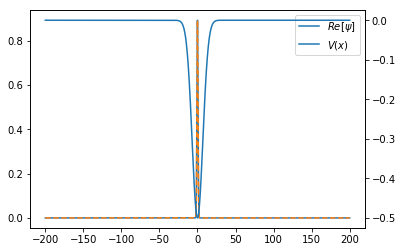

In [10]:
fig_ini, ax_ini = plt.subplots()
l_sf_real, = ax_ini.plot(sys.x_arr, sys.sf_arr.real)
l_sf_abs, = ax_ini.plot(sys.x_arr, np.abs(sys.sf_arr), '--')

ax_energy = ax_ini.twinx()
l_pot, = ax_energy.plot(sys.x_arr, sys.V_x_arr, '-')

ax_ini.legend((l_sf_real, l_pot),(r'$Re[\psi]$','$V(x)$'))

# Construct potential arrays: $V(x)$, $A(t)$

In [11]:
# V_x_arr = sys.V_x_func(sys.x_arr)

### Check by plotting

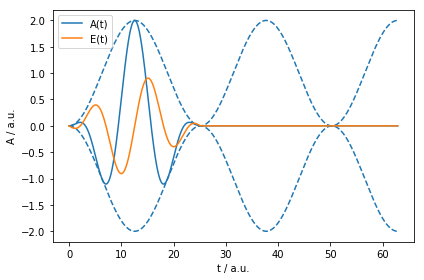

In [12]:
A_t_arr = sys.A_t_func(sys.t_arr)

from tdse.finite_difference import get_first_deriv
E_t_arr = - get_first_deriv(A_t_arr, sys.delta_t_real, zero_boundary=False)
F_t_arr = - E_t_arr

figA, axA = plt.subplots()
A_t_arr = sys.A_t_func(sys.t_arr)
line_A, = axA.plot(sys.t_arr, A_t_arr)
env_arr = A0 * np.square(np.sin(omega / (2*num_cycle) * sys.t_arr))
axA.plot(sys.t_arr, env_arr, sys.t_arr, -env_arr, color=line_A.get_color(), linestyle='--')
axA.set_xlabel("t / a.u."), axA.set_ylabel("A / a.u.")

line_E, = axA.plot(sys.t_arr, E_t_arr)

axA.legend((line_A,line_E), ("A(t)", "E(t)"))

figA.tight_layout()

In [13]:
# figA.savefig("At-and-Et-test.png")

# [TODO] Separate the static part of the Hamiltonian and the time evolution operator from the time-dependent parts

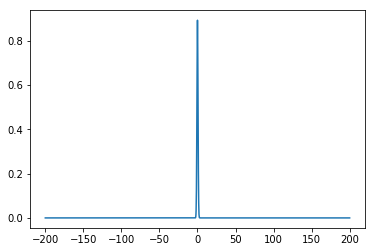

In [14]:
figsf, axsf = plt.subplots()
axsf.plot(sys.x_arr, sys.sf_arr.real)

In [15]:
# sys.propagate(start_t_idx=0, num_timestep=500, imag_prop=True)

<IPython.core.display.Javascript object>


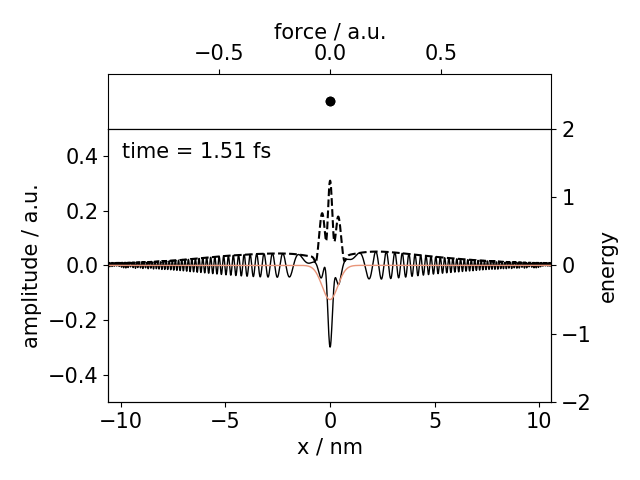

In [16]:
from nunit.au import au2si
au2nm = au2si['length'] * 1e9
au2fs = au2si['time'] * 1e15

%matplotlib notebook

from matplotlib.animation import FuncAnimation

N_off = 10
t_index_arr = np.arange(0, sys.N_timepoint, N_off)
N_frame = t_index_arr.size

figani, (axE, axani) = plt.subplots(2, 1,  gridspec_kw={'height_ratios': [1, 5], 'hspace':0.0})

axpot = axani.twinx()
line_pot, = axpot.plot([],[], color='darksalmon', linewidth=1.0)
axpot.set_ylim(-2,2)
axpot.set_ylabel("energy")

from vis.layout import get_text_position_and_inner_alignment
pos_xy, pos_kw = get_text_position_and_inner_alignment(axani, 'nw')

line_sf, = axani.plot([],[], linewidth=1.0, color='black')
line_sf_abs, = axani.plot([],[], color=line_sf.get_color(), linestyle='--')
line_E, = axE.plot([],[], color='black', marker='o')
# axE.plot([0],[0], color=line_E.get_color(), marker='.')

F_max = np.abs(F_t_arr).max()
axE.xaxis.set_ticks_position('top')
axE.xaxis.set_label_position('top')
axE.set_xlim(-F_max*1.1,F_max*1.1)
axE.set_xlabel("force / a.u.")
axE.yaxis.set_ticks([])

# axani.set_xlim(sys.x_arr[0],sys.x_arr[-1])
axani.set_xlim(-200*au2nm,200*au2nm)
axani.set_ylim(-0.5, 0.5)
axani.set_xlabel("x / nm"), axani.set_ylabel("amplitude / a.u.")

fargs = (line_sf, line_sf_abs, t_index_arr)

text_time = axani.text(*pos_xy, "", fontdict=pos_kw)

text = axani.text(0,0.2,"")

figani.tight_layout()

def init_frame():
    sys.propagate(start_t_idx=0, num_timestep=sys.N_timestep, imag_prop=True)
    sys.sf_arr[:] = sf_arr_0
    return (line_sf, line_sf_abs)

_x_arr = sys.x_arr * au2nm

def update_frame(frame_index, line_sf, line_sf_abs, t_index_arr):
    try:
        _do_propagate_for_next_frame = frame_index > 0 #frame_index < (t_index_arr.size - 1)
        if _do_propagate_for_next_frame:
            sys.propagate(start_t_idx=t_index_arr[frame_index-1], num_timestep=(t_index_arr[frame_index]-t_index_arr[frame_index-1]))
        
        _t_index = t_index_arr[frame_index]
        
        line_sf.set_data(_x_arr, sys.sf_arr.real)
        line_sf_abs.set_data(_x_arr, np.abs(sys.sf_arr))
        line_E.set_data([0, F_t_arr[_t_index]], [0,0])
        line_pot.set_data(_x_arr, sys.V_x_arr + E_t_arr[_t_index] * _x_arr)
        
        _t_au = sys.t_arr[_t_index]
        text_time.set_text("time = {:3.2f} fs".format(_t_au * au2fs))
            
    except Exception as e: text.set_text("ERROR: '{}'".format(e))
        
    return (line_sf, line_sf_abs)

ani = FuncAnimation(figani, update_frame, frames=N_frame, init_func=init_frame, fargs=fargs, repeat=False, blit=True)

In [17]:
from matplotlib.animation import ImageMagickWriter
# ani.save("ani-with-Ft-pot-after-2.gif", writer=ImageMagickWriter())

# #

In [13]:
sys.propagate(0, 50, imag_prop=False)

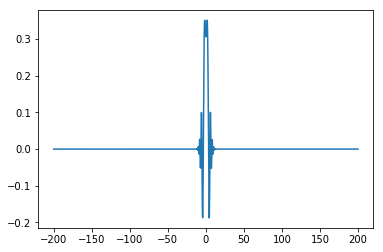

In [14]:
fig_, ax_ = plt.subplots()
ax_.plot(sys.x_arr, sys.sf_arr.real)

In [15]:
sys.propagate(50, 101, imag_prop=False)

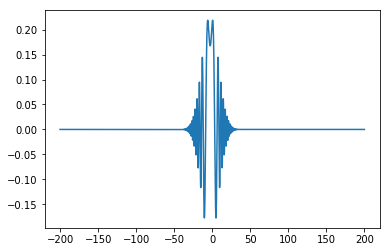

In [16]:
fig_, ax_ = plt.subplots()
ax_.plot(sys.x_arr, sys.sf_arr.real)

# Analytical result

In [11]:
sf_arr_ana = np.empty_like(sf_arr_0, dtype=complex)
# sf_arr_ana[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)
# sf_arr_ana = np.zeros_like(sf_arr_0)

# from tdse.analytic import harmonic_oscillator_eigenfunc
# sf_arr_ana[:] = harmonic_oscillator_eigenfunc(x_arr, 0, omega_pot)


### For field-free gaussian
sf_arr_ana_gauss = np.empty_like(sf_arr_0, dtype=complex)
sf_arr_ana_gauss[:] = Gaussian1D(x_arr, t=t_max, k_x=0.0)


### For volkov state
from tdse.volkov import free_space_volkov
t_idx = N_timepoint - 1
sf_arr_ana[:] = free_space_volkov(x_arr, sf_arr_0, t_idx, t_arr, A_t_func)

# Propagation

- [ ] Later, consider putting the imaginary (thus norm-absorbing) potential into the real part of the unitary operator

In [12]:
from tdse.integral import normalize_trapezoid
from numbers import Integral

from tdse.evol import get_M2_tridiag, get_D2_tridiag, mul_tridiag_and_diag, get_M1_tridiag, get_D1_tridiag


def prop_1d_with_field(start_t_idx, num_timestep, t_arr, delta_t_real, A_t_func, 
                       V_x_arr, sf_arr, x_arr, imag_prop):
    
    ## Check input arguments
    assert isinstance(num_timestep, Integral) and num_timestep > 0

    ## Configure time propagation
    _delta_t = delta_t_real
    if imag_prop: 
        _delta_t *= (-1.0j)
        A_t_func = lambda t: np.zeros_like(t)
    
    N_x = x_arr.size
    delta_x = x_arr[1] - x_arr[0]
    M2 = get_M2_tridiag(N_x)
    D2 = get_D2_tridiag(N_x, delta_x)
    M2V = mul_tridiag_and_diag(M2, V_x_arr)
    M1 = get_M1_tridiag(N_x)
    D1 = get_D1_tridiag(N_x, delta_x)
    
    
    ## Allocate memory 
    # for intermediate result
    _sf_arr_mid = np.empty_like(sf_arr, dtype=complex)
    #
    # for time-evolution operator
    _tridiag_shape = (3,x_arr.size)
    _UA = np.empty(_tridiag_shape, dtype=complex)
    _UA_conj = np.empty(_tridiag_shape, dtype=complex)
    _U0_half = np.empty(_tridiag_shape, dtype=complex)
    _U0_conj_half = np.empty(_tridiag_shape, dtype=complex)
    _U0 = np.empty(_tridiag_shape, dtype=complex)
    _U0_conj = np.empty(_tridiag_shape, dtype=complex)

    ## Construct unitary time evolution operators
    _U0_half[:] = M2 - 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
    _U0_conj_half[:] = M2 + 1.0j * _delta_t * 0.25 * (-0.5 * D2 + M2V)
    _U0[:] = M2 - 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)
    _U0_conj[:] = M2 + 1.0j * _delta_t * 0.5 * (-0.5 * D2 + M2V)
    
    
    _t_idx = start_t_idx
    _t = 0.5 * (t_arr[_t_idx] + t_arr[_t_idx+1])  # use the middle time point for each timestep
    _A_t = A_t_func(_t)

    _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
    _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

    tridiag_forward(_U0_half, sf_arr, _sf_arr_mid)
    tridiag_backward(_U0_conj_half, sf_arr, _sf_arr_mid)
    tridiag_forward(_UA, sf_arr, _sf_arr_mid)
    tridiag_backward(_UA_conj, sf_arr, _sf_arr_mid)

    for _t_idx in range(start_t_idx+1,start_t_idx+num_timestep):

        if imag_prop: normalize_trapezoid(x_arr, sf_arr)

        _t = 0.5 * (t_arr[_t_idx] + t_arr[_t_idx+1])
        _A_t = A_t_func(_t)

        _UA[:] = M1 - _delta_t * 0.5 * _A_t * D1
        _UA_conj[:] = M1 + _delta_t * 0.5 * _A_t * D1

        tridiag_forward(_U0, sf_arr, _sf_arr_mid)
        tridiag_backward(_U0_conj, sf_arr, _sf_arr_mid)
        tridiag_forward(_UA, sf_arr, _sf_arr_mid)
        tridiag_backward(_UA_conj, sf_arr, _sf_arr_mid)

    tridiag_forward(_U0_half, sf_arr, _sf_arr_mid)
    tridiag_backward(_U0_conj_half, sf_arr, _sf_arr_mid)

    if imag_prop: normalize_trapezoid(x_arr, sf_arr)

In [13]:
prop_1d_with_field(0, N_timestep, t_arr, delta_t_real, A_t_func, 
                   V_x_arr, sf_arr, x_arr, imag_prop=False)

## Plot

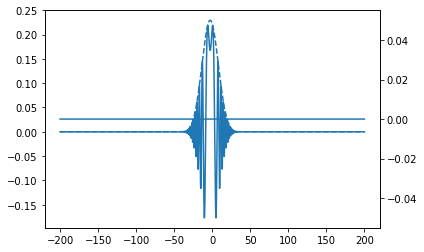

In [14]:
fig_sf, ax_sf = plt.subplots()
l_sf_real, = ax_sf.plot(x_arr, sf_arr.real)
l_sf_abs, = ax_sf.plot(x_arr, np.abs(sf_arr), '--', color=l_sf_real.get_color())

ax_energy = ax_sf.twinx()
l_pot, = ax_energy.plot(x_arr, V_x_arr, '-')

ax_ini.legend((l_sf_real, l_pot),(r'$Re[\psi]$','$V(x)$'))

# Error estimation

In [15]:
err_arr = np.empty(sf_shape, dtype=float)
if imag_prop: err_arr[:] = np.abs(sf_arr) - np.abs(sf_arr_ana)
else: err_arr[:] = np.abs(sf_arr - sf_arr_ana)

# Visualization

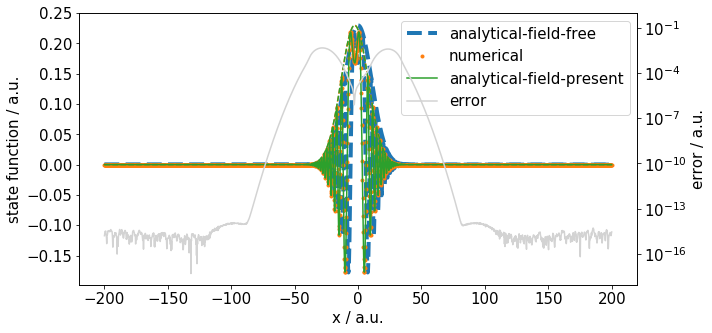

In [17]:
fig, ax = plt.subplots(figsize=(10,5))

l_gauss, = ax.plot(x_arr, sf_arr_ana_gauss.real, '--', linewidth=4)
ax.plot(x_arr, np.abs(sf_arr_ana_gauss), '--', color=l_gauss.get_color(), linewidth=4)

l_num, = ax.plot(x_arr, sf_arr.real,'.')
ax.plot(x_arr, np.abs(sf_arr), '--', color=l_num.get_color())

l_ana, = ax.plot(x_arr, sf_arr_ana.real)
ax.plot(x_arr, np.abs(sf_arr_ana), '--', color=l_ana.get_color())
ax.set_xlabel("x / a.u.")
ax.set_ylabel("state function / a.u.")

ax2 = ax.twinx()
l_error, = ax2.semilogy(x_arr, err_arr, color='lightgrey')
ax2.set_ylim(None,1)
ax2.set_ylabel('error / a.u.')

ax.legend((l_gauss, l_num, l_ana, l_error),('analytical-field-free', 'numerical','analytical-field-present','error'))

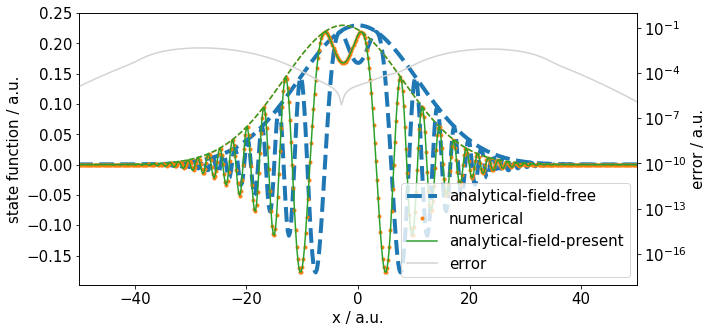

In [18]:
ax.set_xlim(-50,50)

fig

In [19]:
# fig.savefig("comparison-field-present-gaussian-seems-good-showing-agreement-2.png")

In [20]:
from tdse.integral import eval_norm_trapezoid

eval_norm_trapezoid(x_arr, err_arr)

0.0004617167907178428